#**Quantum Mechanics / Molecular Mechanics (QM/MM) Calculations**

Combined QM/MM approaches are used for modeling chemical reactions and  electronic properties in biomolecular systems.

When modeling chemical reactions, these approaches
*   use a **QM** method for **chemically active** sites and
*   an **MM** treatment for **surrounding** regions.


Overview of the QM/MM Hamiltonian in a biomolecular system

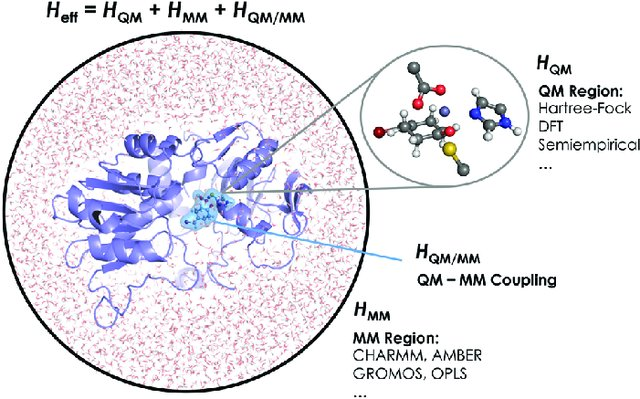     
Figure 1: QM/MM approach of a biomolecular environment   
(Source: Romero-Rivera, A., Garcia-Borràs, M. and Osuna, S., 2017. Computational tools for the evaluation of laboratory-engineered biocatalysts. *Chemical Communications*, 53(2), pp.284-297)

## Potential Energy of System

The potential energy $E_\mathrm{sys}$ of a system consisting of both QM and MM regions is;

\begin{align}
E_\mathrm{sys} = E_\mathrm{QM} + E_\mathrm{MM} + E_\mathrm{QM/MM}
\end{align}

The potential energy of the MM region, $E_\mathrm{MM}$, consists of several terms including,

\begin{align}
E_\mathrm{bonded} & = E_\mathrm{bond} + E_\mathrm{angle} + E_\mathrm{torsion} \\
E_\mathrm{nonbonded} & = E_\mathrm{LJ} + E_\mathrm{Coul} \\
E_\mathrm{LJ} & = \sum_{A>B} 4 \epsilon_{AB}
\left[ \left( \frac{\sigma_{AB}}{R_{AB}} \right)^{12}
- \left( \frac{\sigma_{AB}}{R_{AB}} \right)^{6}
\right] \\
E_\mathrm{Coul} & = \sum_{A>B} \frac{q_A q_B}{R_{AB}}
\end{align}

where $R_{AB} = |\pmb{R}_B - \pmb{R}_A|$

$\epsilon$, $\sigma$, and $q$ are MM force field parameters. The parameters will depend on the choice of **biomolecular force field**, which include:


1. AMBER
2. CHARMM
3. MMFF
4. OPLS
5. AMOEBA



The energy of the QM region is based on the Born-Oppenheimer Approximation, a well-established approximation based on electrons neglecting the motion of the nucleus. The underlying physical basis is that the mass of nucleus is much larger than that of an electron. Based on this approximation, **electron density $\rho_\mathrm{elec} (r)$ is obtained in a field of fixed nuclei**.

\begin{align}
\hat{H}_\mathrm{elec} & =  - \sum_{i=1}^N \frac{1}{2} \nabla_i^2 - \sum_{i=1}^N\sum_{A=1}^M \frac{Z_A}{|\pmb{r}_i - \pmb{R}_A|}  + \sum_{i = 1}^N \sum_{j>i}^N \frac{1}{|\pmb{r}_i - \pmb{r}_j|} \\
E_\mathrm{elec} & =  \langle \Psi_\mathrm{elec} | \hat{H}_\mathrm{elec} | \Psi_\mathrm{elec} \rangle \\
E_\mathrm{QM} & =  E_\mathrm{elec} + \sum_{A = 1}^M \sum_{B>A}^M \frac{1}{|\pmb{R}_A - \pmb{R}_B|}
\end{align}

## Calculating $E_\mathrm{QM}$

Two key choices in QM calculations are the level of theory and the basis set. Each choice leads to a different tradeoff between accuracy and computational cost.

### Levels of Theory



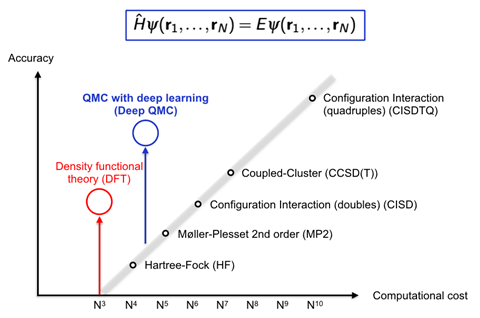       
Figure 2: QM Theory levels. (Source: Article on quantum chemistry simulations. [Link](https://www.chemistryworld.com/news/quantum-chemistry-simulations-offers-beguiling-possibility-of-solving-chemistry/4011541.article)  )

In this notebook, we will perform a calculations at the HF and MP2 levels of theory.

The Hartree-Fock (HF) method is based on an approximation to the electronic Schrödinger equation where each electron experiences only the average Coulomb repulsion of all the other electrons. Thus, it can be considered a self-consistent field (SCF) method. The electron spin is not taken into account, so the equations do not satisfy the Pauli Exclusion Principle. It is assumed that all electrons are independent; a given electron interacts with the other electrons only through the mean field Coulomb potential.


### Basis sets

A basis set is a set of functions combined linearly to generate molecular orbitals (mostly atomic orbitals centered on atoms). Gaussian-Type Orbital (gto) basis sets are very popular. They have a Gaussian functional form such as $\phi_{p_y} =  y \exp(-[x^2+y^2+z^2])$.

To learn more about basis sets, click [here](https://gaussian.com/basissets/).


#**Part 0 - Setting up the required software**

In [ ]:
# Install pyscf (Python-based Simulations of Chemistry Framework,
#                for QM electronic structure calculation)
!pip install pyscf
!pip install -U pyberny
!pip install pdb2pqr

The following code cells will many of the required packages, if you are working on [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb). Installing the [condacolab](https://github.com/jaimergp/condacolab) package will restart the kernel.

In [ ]:
try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install_mambaforge()
except ModuleNotFoundError:
    pass

In [ ]:
try:
    import condacolab
    condacolab.check()
    !mamba install -c conda-forge ambertools openbabel openmm cudatoolkit py3Dmol --yes
except ModuleNotFoundError:
    on_colab = False
else:
    #check if installation was succesful
    try:
        import openbabel, openmm
        on_colab = True
        from IPython.display import clear_output
        clear_output()  # clear the excessive installation outputs
        print("Dependencies successfully installed!")
    except ModuleNotFoundError:
        print("Error while installing dependencies!")

In [ ]:
from pyscf import gto, scf, mp, qmmm
from pyscf.geomopt.berny_solver import optimize
import numpy as np

If you are running this code with a GPU, you should use CUDA to perform the molecular mechanics calculations. Otherwise use the CPU platform.

In [ ]:
OpenMM_Platform = 'CPU'
# OpenMM_Platform = 'CUDA'

#**Part I - Water**

We will first build and minimize a model of a single water molecule. Afterwards, we will look into the effect of the set of point charges representing surrounding water molecules.

First, we need to define a system with the atomic coordinates of a water molecule.

In [ ]:
# Estimate potential energy and gradients using different basis sets
mol = gto.Mole() # Gaussian-type orbitals
# Specify elements and coordinates, in Angstroms
mol.atom = '''
 O     0.570717    -1.720662    -0.481407
 H     1.689790    -1.221338    -0.305275
 H     1.142439    -2.587970    -0.779946
'''
mol.verbose = 0

mol.basis = '631g'
mol.build()
mf_hf = scf.RHF(mol).run() # mf represents 'mean-field'
print (f'HF energy: {mf_hf.e_tot:12.5f} Hartrees')

# Peform the Geometry Optimization and get the optimized (minimized) potential energy
mol_eq = optimize(mf_hf)
mf_hf_eq = scf.RHF(mol_eq).run()
ener_monomer_min = mf_hf_eq.e_tot
print (f'Minimized HF energy: {mf_hf_eq.e_tot:12.5f} Hartrees')
print ('Minimized Coordinates:\n', mol_eq.atom_coords(unit='Angstroms'))

## Evaluating embedding field effects

The QM/MM Hamiltonian includes some terms due to the embedding field ($\{ q_B \}$) from the MM region.

\begin{align}
\hat{H}_\mathrm{QM:MM} =\hat{H}_{I:Q_I} & =  \hat{H}_{I} +  \sum_{A \in I} \sum_{B \in Q_I} \frac{Z_A q_B}{|\pmb{R}_A - \pmb{R}_B|}  - \sum_{i \in I} \sum_{B \in Q_I} \frac{q_B}{|\pmb{r}_i - \pmb{R}_B|},
\end{align}

This embedding field alters the wave function to $\Psi_{I:Q_I}$, such that $|\Psi_{I:Q_I}|^2 \neq |\Psi_I|^2$. The ground-state energy is,
\begin{align}
E_\mathrm{QM/MM} & = \langle \Psi_{I:Q_I} | \hat{H}_{I:Q_I} | \Psi_{I:Q_I} \rangle
\end{align}


In [ ]:
# MM Coordinates
mm_coords = np.array ([
   [ -0.739828,    0.404042,   -1.654300],
   [ -0.272313,   -0.431908,   -1.528862],
   [ -1.614079,    0.247681,   -1.263516],
   [  0.583010,    1.747649,    0.237412],
   [  0.067638,    1.388447,   -0.522507],
   [  0.492157,    2.699374,    0.198453],
   [ -0.691372,   -0.486623,    1.662094],
   [ -0.196696,   -1.092424,    1.095426],
   [ -0.275026,    0.366763,    1.487915],
   [  2.806577,    0.107881,    0.110541],
   [  2.167450,    0.835600,    0.198078],
   [  3.312599,    0.107696,    0.923627],
   [ -2.902522,    0.004488,    0.074388],
   [ -2.270920,   -0.248552,    0.771495],
   [ -3.659225,   -0.571176,    0.176758]
])
# A MM charge on each MM particle
mm_charges= np.array([
  -0.87270,
   0.41814,
   0.45456,
  -0.82369,
   0.48143,
   0.34226,
  -0.83501,
   0.41222,
   0.42279,
  -0.80161,
   0.41908,
   0.38253,
  -0.82897,
   0.43249,
   0.39648
])

mf_qmmm = qmmm.mm_charge(mf_hf, mm_coords, mm_charges)
mf_qmmm.run()

print (f'QM/MM energy: {mf_qmmm.e_tot} Hartrees')

Now we will visualize how the embedding field changes the electron density.

In [ ]:
# Write volumetric data
from pyscf.tools import cubegen
resolution = 0.25
cubegen.density(mol_eq, 'density_qm.cube', \
  mf_hf_eq.make_rdm1(), resolution=resolution); # density
cubegen.density(mol_eq, 'density_qmmm.cube', \
  mf_qmmm.make_rdm1(), resolution=resolution); # density

# Read volumetric data
vol = {}
for data_type in ['density_qm','density_qmmm']:
  vol[data_type] = open(data_type + ".cube", "r").read().strip()

# Compute and store density difference
density_difference = \
  [[float(val_qmmm) - float(val_qm) \
    for (val_qmmm, val_qm) in zip(line_qmmm.split(), line_qm.split())] \
      for (line_qmmm, line_qm) in zip(vol['density_qmmm'].split('\n')[9:], vol['density_qm'].split('\n')[9:])]

density_difference_min = np.min([np.min(line) for line in density_difference])
density_difference_max = np.max([np.max(line) for line in density_difference])
print(f'Density difference ranges between {density_difference_min:.5f} and {density_difference_max:0.5f}')

vol['density_difference'] = '\n'.join(vol['density_qmmm'].split('\n')[:9] + \
  [''.join([f'{val:13.5e}' for val in line]) for line in density_difference])

In [ ]:
# Show isosurfaces of the electron density difference
import py3Dmol
v = py3Dmol.view()
v.addVolumetricData(vol['density_difference'], "cube", \
 {'isoval': 0.0025, 'opacity':.9, 'color':'blue'});
v.addVolumetricData(vol['density_difference'], "cube", \
 {'isoval': -0.0025, 'opacity':.9, 'color':'red'});
v.addModel(mol_eq.tostring('xyz'), 'xyz')
v.setStyle({'stick':{}})
v.zoomTo()
v.show()

#### --> Describe how the embedding field alters the electron density of the water molecule.

**Electronic Energy between a molecule and the embedding field ($\{q_B\}$)**

\begin{align}
E_I^\mathrm{elec} & =  \langle \Psi_{I:Q_I} | \hat{H}_{I:Q_I} | \Psi_{I:Q_I} \rangle
            - \langle \Psi_{I} | \hat{H}_{I} | \Psi_{I} \rangle
\end{align}

**Polarization Energy**

\begin{align}
E_I^\mathrm{pol} & =  \langle \Psi_{I:Q_I} | \hat{H}_{I:Q_I} | \Psi_{I:Q_I} \rangle
            - \langle \Psi_{I} | \hat{H}_{I:Q_I} | \Psi_{I} \rangle
\end{align}

**Coulomb interaction between a molecule and the embedding field**
\begin{align}
E_{I:Q_I}^\mathrm{Coul} = \langle \Psi_I | \sum_{A \in I} \sum_{B \in Q_I} \frac{Z_A q_B}{|\pmb{R}_A - \pmb{R}_B|}  - \sum_{i \in I} \sum_{B \in Q_I} \frac{1}{|\pmb{r}_i - \pmb{R}_B|} | \Psi_I \rangle
\end{align}


Execute the following commands to deduce these energies;

In [ ]:
e_elec = mf_qmmm.e_tot - mf_hf.e_tot
print ('Eelec', e_elec)
# Get dm_hf = <\Psi_I| \Psi_I>
dm_hf = mf_hf.make_rdm1()
# Get a polarization energy
e_pol = mf_qmmm.e_tot - mf_qmmm.energy_tot(dm_hf)
print ('Epol ', e_pol)

print ('Ecoul', e_elec - e_pol)

#**Part II - An enzyme with a catalytic triad**

A catalytic triad is a set of three coordinated amino acids that can be found in the active site of some enzymes. They include an Acid, Base, and Nucleophile that can be the following residues:
- Acid - aspartate, glutamate   
- Base - histidine
- Nucleophile - serine (-OH) or cysteine (-SH)
There are two steps to a reaction catalyzed by a catalytic triad:
- Proton transfer
- Nucleophilic attack

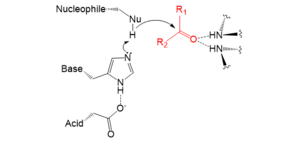   
The triad system with proton tranfer and Nu attack   
(Source: https://en.wikipedia.org/wiki/Catalytic_triad)

This part of the lab will show how to calculate energies for the reaction catalyzed by TEV protease (PDB ID: [1LVM](https://www.rcsb.org/structure/1lvm)). TEV protease uses a catalytic triad of residues to catalyze peptide hydrolysis. Opposed to the serine from the conventional Ser-Asp-His triad, TEV protease uses cysteine instead.

For this exercise, you are **only** expected to complete up to step 3. The remaining steps are for reference in case you would like to use this notebook in your project.

## **Step 0**: Download input files and scripts

In [ ]:
# CONTENT SPECIFIC TO LAB
import os
if not os.path.isdir('./modelingworkshop'):
  !git clone https://github.com/swillow/modelingworkshop

if not os.path.isdir('./pdb2amber'):
  !git clone https://github.com/swillow/pdb2amber

for step in range(8):
  if not os.path.isdir(f'step{step}'):
    os.mkdir(f'step{step}')

## **Step 1**: Use pdb2pqr to add hydrogen atoms to the PDB file

In [ ]:
# Show the arguments that can be passed to pdb2pqr
!pdb2pqr30 --help | head -n15
!echo

# Define arguments and execute pdb2pqr
pdb_in = os.path.join('modelingworkshop', 'exercise', 'TEV', '1lvm_A.pdb')
assert os.path.isfile(pdb_in)
prefix = '1lvm_A_H'

!pdb2pqr30 --ff=AMBER --with-ph=7 --nodebump --ffout=AMBER {pdb_in} step1/{prefix}.pqr

In [ ]:
# Convert the pqr file to a pdb file with hydrogens
!python ./modelingworkshop/exercise/step1_AddH/pqr2pdb.py -i step1/{prefix}.pqr -o step1/{prefix}.pdb

In [ ]:
print('Number of lines in the original pdb file and the pdb file with H:')
!wc -l {pdb_in}
!wc -l step1/{prefix}.pdb
!echo
print('Head of the original pdb file and the pdb file with H:')
!head -n20 {pdb_in}
!echo
!head -n20 step1/{prefix}.pdb

## **Step 2**: Generate an AMBER Parameter/Topology file (prmtop) for the QM/MM system (using pdb2amber.py)


In [ ]:
# Define arguments in a json file
step2_in = {
    "fname_pdb":    os.path.abspath(f"step1/{prefix}.pdb"),
    "fname_prmtop": os.path.abspath(f"step2/{prefix}.prmtop"),
    "fname_inpcrd": os.path.abspath(f"step2/{prefix}.inpcrd"),
    "fname_ff": [
        os.path.abspath("./pdb2amber/data/protein.ff14SB.xml"),
        os.path.abspath("./pdb2amber/data/wat_opc3.xml")
    ]
}
import json
json.dump(step2_in, open(f"step2/step2.json",'w'), indent=2)

# Execute pdb2amber
!python pdb2amber/pdb2amber.py -i step2/step2.json

In [ ]:
!head -n20 step2/{prefix}.prmtop

## **Step 3**: Minimize the protein structure within the QMMM system (using qmmm_pol.py)


In [ ]:
# These dictionary contains parameters for the QMMM system
# Similar parameters will be used in subsequent steps
step3_in = {
    "theory": "qmmm",
    "_job_info": "choose either ener, opt, or mm_opt",
    "job": "mm_opt",
    "geom": {
        "ligand": os.path.abspath(f"modelingworkshop/exercise/TEV/ligand_short.pdb"),
        "protein": os.path.abspath(f"step1/{prefix}.pdb"),
        "_qm_residues_info": "provide dict as [res_id] =  charge, Here, 'res_id' is given as 'res_nm + res_num'",
        "qm_residues": {
            "LIG1": 0,
            "CYS151": 0,
            "HID46": 0
        },
        "_constraints_info": "[ res_id1:atom_id1, res_id2:atom_id2, k0 (kcal/mol/A^2), r0(Angstrom)]",
        "constraints": [ ["CYS151:HG","HID46:NE2", 0.0, 1.0],
		                     ["CYS151:SG","LIG1:C4", 0.0, 1.8] ]
    },
    "qm": {
	"_method_info" : "rhf is supported",
        "method": "rhf",
	"_basis_info" : "provide basis set",
        "basis": "sto-3g",
        "esp_opts": {
            "resp": True,
            "resp_hfree": True
        }
    },
    "mm": {
	"_mm_info" : "MM energy and gradients are estimated via OpenMM",
        "Platform": OpenMM_Platform,
	"_fname_prmtop_info" : "MM force field is provided in an AMBER prmtop format",
        "fname_prmtop": os.path.abspath(f"step2/{prefix}.prmtop")
    },
    "geomopt": {
        "fname_gopt_xyz": "gopt.xyz",
        "fname_gopt_log": "gopt.log",
        "fname_lig_pdb": os.path.abspath(f"step3/ligand_optimized.pdb"),
        "fname_prt_pdb": os.path.abspath(f"step3/protein_optimized.pdb")
    }
}

The code below sets up the QMMMPol class and avoids some import errors

In [ ]:
import numpy as np
import openmm.unit as unit
from openmm import app
import openmm as omm

import sys
import xml.etree.ElementTree as etree

import time
from pyscf import gto, scf, mp, qmmm, grad, lib
import pyscf
from pyscf.data.nist import BOHR, HARTREE2J, AVOGADRO
from openmm.unit import constants
from berny import Berny, geomlib

from modelingworkshop.QMMM import esp
from modelingworkshop.QMMM.esp import esp_atomic_charges, make_rdm1_with_orbital_response
from modelingworkshop.QMMM import _geom

with open('modelingworkshop/QMMM/_pyscf.py','r') as F:
  lines = F.readlines()
exec(''.join(lines[4:]))

with open('modelingworkshop/QMMM/qmmm_pol.py','r') as F:
  lines = F.readlines()
exec(''.join(lines[19:635]))

In [ ]:
calc = QMMMPol(step3_in)
calc.run()

#### --> By how much does the minimization reduce the energy of the system?

**References**

Romero-Rivera, A., Garcia-Borràs, M. and Osuna, S., 2017. Computational tools for the evaluation of laboratory-engineered biocatalysts. *Chemical Communications*, 53(2), pp.284-297

Ryde, U., 2016. QM/MM Calculations on Proteins. *Methods in Enzymology*, pp.119-158.

Modelling Workshop 2021 (https://github.com/swillow/modelingworkshop.git)    

https://www.chemistryworld.com/news/quantum-chemistry-simulations-offers-beguiling-possibility-of-solving-chemistry/4011541.article



**Acknowledgements**   

Soohaeng Yoo Willow, Research Assistant Professor;
Joseph Depaolo-Boisvert, PhD Student in Chemistry;
Sivanujan Suthaharan, PhD Student in Chemistry

**End of the QM/MM session**  
Have a good day! 😊



